# Ch 9 - Hierarchical Models
Hierarchical Models are those where the model parameters are dependent on some other thing. For example, we might be trying to model probabilities of coin biases ($\theta$) but where our coins all come from the same factory Hierarchical Models give us the tools to integrate a 'factory bias' component' as well. This is especially helpful in cases where we want our model parameter to have integrated some kind of knowledge about the larger population as a whole; e.g. if $\theta$ is the chance of patient complication of a ward in a hospital and we want to integrate $\omega$ the same measure for other similar wards in all of the hospitals for which we have data.

In terminology, $\theta$ is generally used to describe model parameters whereas $\omega$ describes the higher level quantity that $\theta$ is somewhat dependent on.

Mathematically using hierarchical models is similar to modeling two joint parameters:

$$p(\theta, \omega  \, | \, D) \propto p(D \, | \, \theta, \omega) \, p(\theta, \omega)$$
$$=p(D \, | \, \theta) \, p(\theta \,|\, \omega) \, p(\omega)$$

Any model that can be factored into a chain of dependencies like the above is a "Hierarchical Model". This generally eventuates if we design the model such that $p(D \, | \, \theta, \omega)$ is the same as $p(D \, | \, \theta)$, which occurs when $\omega$ has no direct bearing on D. This might seem unclear, but remember that $(A|B,C)$ is the same as $(A|B|C)$. If A isn't directly dependent on C (only through B) then we can drop it, since the value of B, when fixed, already implies a fixed value of C also.

Recall that for our coin flips:
$$p(D\, | \, \theta) = \theta^z\,(1-\theta)^{(N-z)}$$

$$p(\theta) = \textrm{beta}(a, b)$$

Recall that since the mode ($\omega$) and concentration ($\kappa$) of a beta distribution are:

$$\kappa = a + b$$

$$\omega = \frac{a - 1}{\kappa - 2}$$

We can re-write the prior as:

$$p(\theta) = \textrm{beta}(\omega(\kappa-2)+1, (1-\omega)(\kappa - 2) + 1)$$

Mechanically, this means that we can control the distribution because we know that the peak will be at $\omega$ and thus that $\theta$ will be generally be near omega. The amount of bunching around the mode is controlled with $\kappa$ so increasing this will make $\theta$ more likely to be near $\omega$.

In our coin minting example, we can think of $\omega$ as the mint bias and $\kappa$ (hereafter just K because it is constant) determines how much a given coin $\theta$ is likely to stray from this mint bias.

Where hierarchical models really start to get groovy though is when we assume that $\omega$ itself is a parameter to estimate.

In this model, our estimates of $\theta$ will largely be based on the ratio of heads and tails (D). Our estimate of $\omega$ will be close to $\theta$ if K is large or otherwise more variable.

To estimate $\omega$ we need to have a prior and likelihood function for it. We can use a beta distribution (one again):


$$p(\omega) = \textrm{beta}(\omega\,|\, A_{\omega}, B_{\omega})$$

Hence we can visualise the flow of the model:

$A_{\omega}, B_{\omega}$ |
-|-
$\downarrow$ |
$\text{beta}$ | $\omega$
$\downarrow$ |
$\omega\,(K-2)+1, (1-\omega)(K-2)+1$ |
$\downarrow$ |
$\text{beta}$ |  $\theta$
$\downarrow$ |
$\textrm{bernoulli}$ | $y_i$



### Heirarchical Coin Flip (grid approximation)

In [9]:
#------------------------------------------
#Omega prior
a_omega_prior = 2
b_omega_prior = 2

get_omega_prior = function(x, a, b){
    return(dbeta(x, a, b)/beta(a, b))
}

#------------------------------------------
#Theta prior

get_theta_prior = function(x, omega, K){
    a = omega * (K - 2) + 1
    b = (1 - omega)*(K - 2) + 1
    
    return(dbeta(x, a, b))
}

#------------------------------------------
#Evidence:
N = 12
z = 9
K = 100

#------------------------------------------
#Likelihood
get_likelihood = function(theta, N, z){
    return(theta ** z * (1-theta) ** (N-z))
}

#------------------------------------------
#Posterior
sample_pts = 100

x_omega = seq(0, 1, length.out = sample_pts)
x_theta = seq(0, 1, length.out = sample_pts)

get_posterior = function(x_o, x_t, a_o, b_o, N, z, K){
    
    p_omega = get_omega_prior(x_o, a_o, b_o)
    p_theta = get_theta_prior(x_t, x_o, K)
    
    likelihood = get_likelihood(x_t, N, z)
    
    return(list(post_theta = likelihood * p_theta * p_omega,
                prior_theta = p_theta,
                prior_omega = p_omega,
                likelihood = likelihood))
}

posterior_theta = c()
prior_omega = c()
prior_theta = c()
likelihood = c()
for (x_o in x_omega){
    for (x_t in x_theta){
        
        result = get_posterior(x_o, x_t, 
                               a_omega_prior, b_omega_prior, 
                               N, z, K)
        
        posterior_theta = append(posterior_theta, result$post_theta)
        likelihood = append(likelihood, result$likelihood)
        prior_theta = append(prior_theta, result$prior_theta * result$prior_omega)
        
    }
    prior_omega = append(prior_omega, result$prior_omega)
}

#Normalise:
posterior_theta = posterior_theta / sum(posterior_theta)


Note that the objects are structured thusly:  
posterior_theta: ((omega_1, theta_1), (omega_1, theta_2), ... )  
likelihood: (same)  
priot_theta: (same)  
prior_omega: (omega_1, omega_2, ... )  

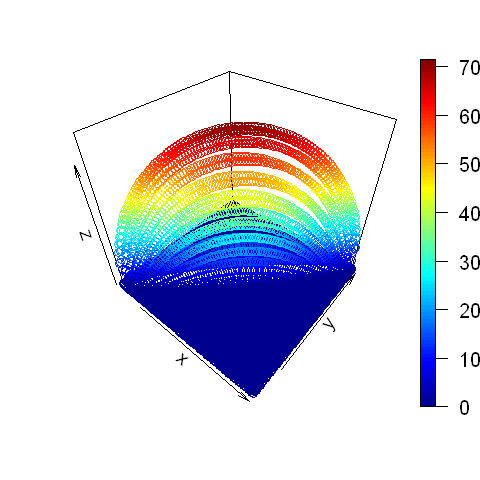

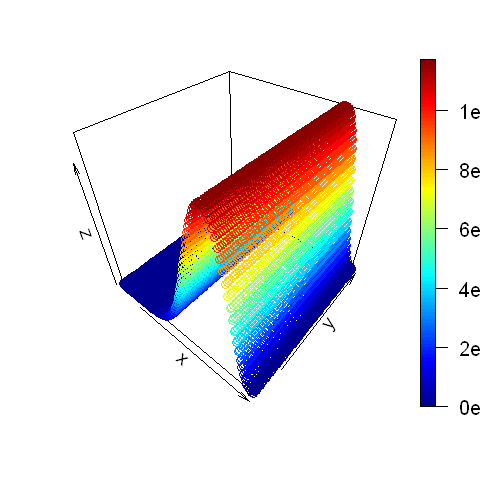

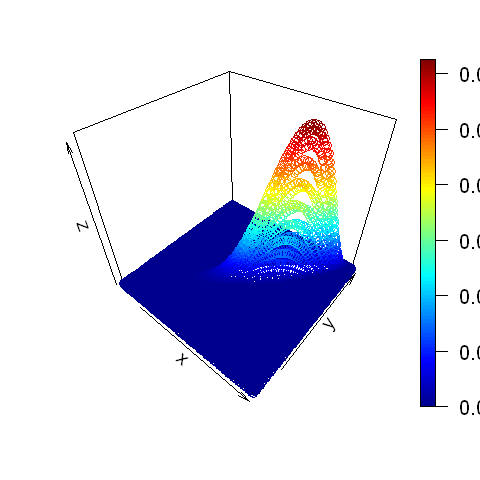

In [10]:
library(repr)
options(repr.plot.width=4, repr.plot.height=4)

#Y = omega, X = theta
plot3D::scatter3D(x = rep(1:sample_pts, sample_pts),
                  y = rep(1:sample_pts, each = sample_pts),
                  z = prior_theta)
plot3D::scatter3D(x = rep(1:sample_pts, sample_pts),
                  y = rep(1:sample_pts, each = sample_pts),
                  z = likelihood)
plot3D::scatter3D(x = rep(1:sample_pts, sample_pts),
                  y = rep(1:sample_pts, each = sample_pts),
                  z = posterior_theta)

^ I'm not 100% sure this model is working perfectly, though it seems to mostly be doing the right thing and TBH it's a bit ambitious to hope for much more given the ridiculous amount of fiddliness and stupid R bullshit I have to deal with hard-coding a grid sampler like this.